[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/csikosmarci24/vitmav45-Mayuyu/tree/main/project/data_visualization.ipynb)

# Download from Google Drive

In [1]:
# graph
!gdown 1Ot-ICpiJRlisFvM9Fi6TM3Q6kAZaLS0y
# DrugBank
!gdown 1LSdAthCa69kWRIKoI5UmclLgf4OsSNAm
# xsd
!gdown 15_hqow9NT_M49OX7cXrG5P6vCgfbKyhP

Downloading...
From: https://drive.google.com/uc?id=1Ot-ICpiJRlisFvM9Fi6TM3Q6kAZaLS0y
To: /content/ChCh-Miner_durgbank-chem-chem.tsv.gz
100% 207k/207k [00:00<00:00, 91.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LSdAthCa69kWRIKoI5UmclLgf4OsSNAm
To: /content/drugbank_all_full_database.xml.zip
100% 152M/152M [00:00<00:00, 226MB/s]
Downloading...
From: https://drive.google.com/uc?id=15_hqow9NT_M49OX7cXrG5P6vCgfbKyhP
To: /content/drugbank.xsd
100% 43.2k/43.2k [00:00<00:00, 49.8MB/s]


# Read files

In [2]:
import gzip
import pandas as pd

with gzip.open('ChCh-Miner_durgbank-chem-chem.tsv.gz') as f:
    graph_data = pd.read_csv(f, delimiter='\t', names=['Source', 'Target'])

In [3]:
graph_data.head()

,Source,Target
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275


In [4]:
import networkx as nx

# gráf készítése - egy ilyen objektumból kell majd a train/valid/test éldiszjunkt gráfokat létrehozni
graph = nx.from_pandas_edgelist(graph_data, source='Source', target='Target')

In [5]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 592 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 53.8 MB/s 
  Created wheel for pyvis: filename=pyvis-0.3.0-py3-none-any.whl size=600250 sha256=b14ff36a2d36bca63a9cd4576d9988b5ad7f869cff8c75b34a78f13d44d9195a
  Stored in directory: /root/.cache/pip/wheels/57/74/32/e404e0d76fbb2dc4e3791b821cfae6a69c1a6677ded99dc8b7
Successfully built pyvis


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


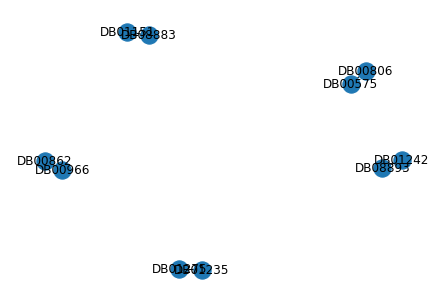

In [14]:
# vizualizáció - első pár él vizualizálása
from pyvis import network as net
from IPython.core.display import display, HTML
graph_part = nx.from_pandas_edgelist(graph_data[0:5], source='Source', target='Target')
g = net.Network(notebook=True)
g.from_nx(graph_part)
nx.draw(graph_part, with_labels=True)

In [12]:
g.show('nx.html')
display(HTML('nx.html'))